In [1]:
import torch
import torchvision
import cv2
from torch import nn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import torchvision.transforms as tt
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights
from sklearn.metrics import accuracy_score

## Loading data

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
torch.random.seed= seed_constant

BATCH_SIZE=10

# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 112, 112

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]


In [3]:
%%capture

# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the Dataset
!unrar x UCF50.rar

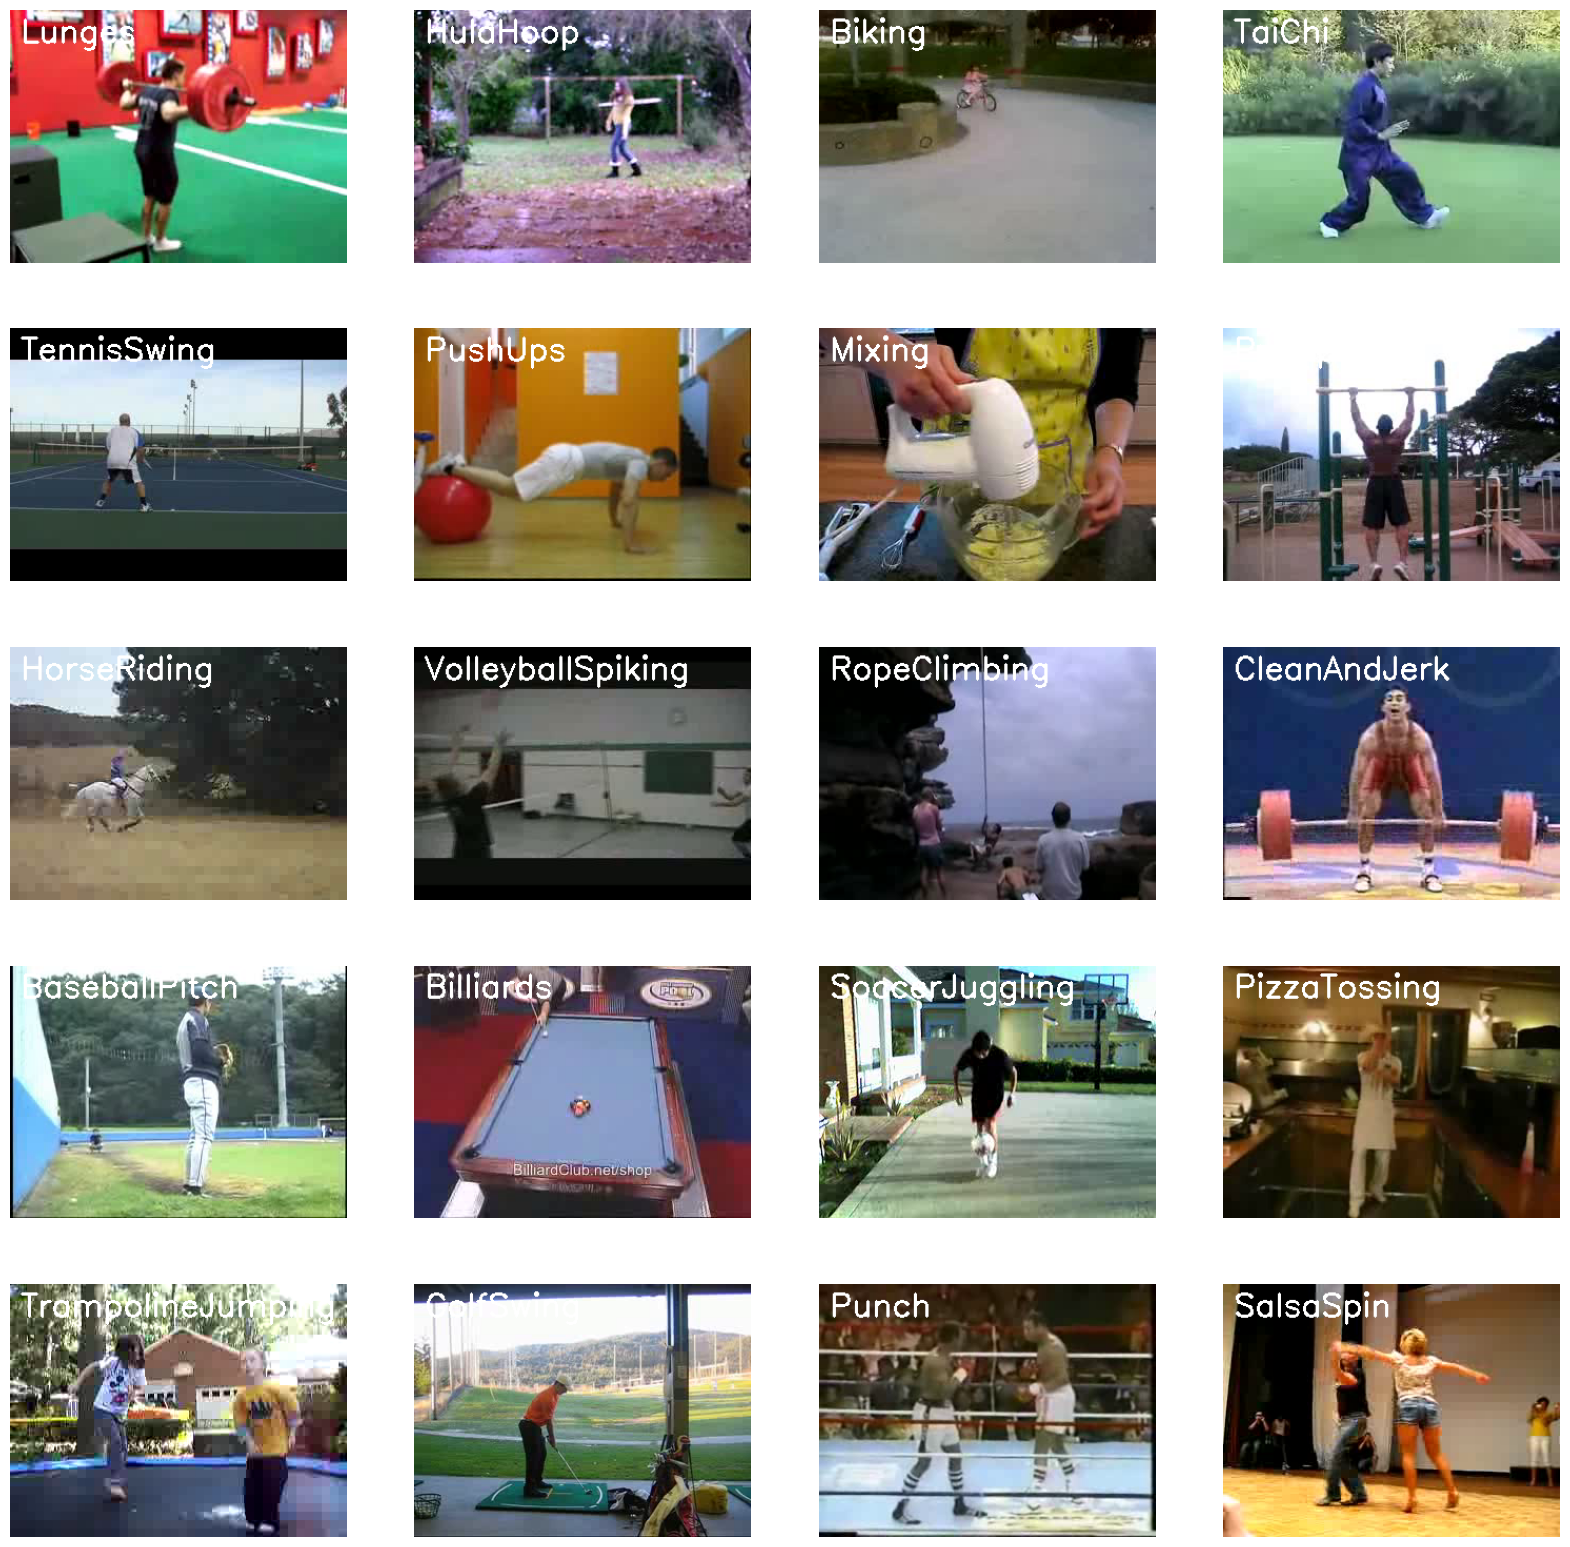

In [4]:
 #Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

## plot_df

In [5]:
# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (12,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }
CMAP = plt.cm.brg

plt.rcParams.update(params)

In [6]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def plot_tf_hist(hist_df):
    '''    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]

    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "{}: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = "{}: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')

    plt.tight_layout()

## Frame Extraction

In [7]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [8]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [9]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


In [10]:
# transforms required by r2plus1d model
r21d_trans=tt.Compose([R2Plus1D_18_Weights.KINETICS400_V1.transforms()])

In [11]:
# functions to apply transforms to each frame
def apply_tansforms(feat):

  # list to store transformed frames
  feats=[]
  for i in range(len(feat)):

      #converting to array and reshaping in required format
      x=np.transpose(np.array(feat[i]), (0,3,1,2))
      # convertin to tensor to apply transforms
      a=torch.Tensor(x)
      # apply transforms and append to the list
      feats.append(r21d_trans(a))
  return feats

In [12]:
# getting list of frames in form of tensors
feats=apply_tansforms(features)

In [13]:
# converting labels to tensors
labels=torch.tensor(labels)
labels.shape

torch.Size([487])

In [14]:
# just verifying
len(feats)

487

## Creating Datasets

In [15]:
# applying train test split
x_train,x_test,y_train,y_test=train_test_split(feats,labels,stratify=labels,test_size=0.25,shuffle=True,random_state=seed_constant)

In [16]:
len(x_train)

365

In [17]:
# checking device
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


In [18]:
# creating classes for creating custom dataset
class ActivityDS(Dataset):
    def __init__(self, featuress,labelss, device = device):
        self.features = featuress
        self.device = device
        self.labels = labelss

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Extract features and label from the features and labels lists
        features = self.features[index]
        labels = self.labels[index]

        # put features and labels onto device
        features = features.to(device)
        labels = labels.to(device)

        return features, labels

In [19]:
# creating training andtesting datasets
train_ds = ActivityDS(x_train,y_train)
test_ds = ActivityDS(x_test,y_test)

In [20]:
# checking the shape of each frame
for i in x_train:
  print(i.shape)
  break

# So 3 channels, 30 time-steps, 112 height and 112 width

torch.Size([3, 30, 112, 112])


## Creating DataLoaders

In [21]:
# Define data loaders for the training and testing datasets
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

## Trochvision transfer learning

### r2plus1

In [22]:
# Loading the model and it's weights
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights


In [49]:
# keeping default weights i.e. for Kinetics dataset
weights=R2Plus1D_18_Weights.DEFAULT
# Initializing the model
r21d=r2plus1d_18(weights=weights,progress=True)
# getting number of input features in the last layer
in_fc=r21d.fc.in_features
in_fc

512

In [50]:
# chaning the output features to match our requirement
r21d.fc=nn.Linear(in_fc,len(CLASSES_LIST),bias=True)

In [51]:
# Freezing all weights except classifier weights and biases,
# So we will only be training classifier and not the main part
for param in r21d.parameters():
   param.requires_grad=False
r21d.fc.weight.requires_grad = True
r21d.fc.bias.requires_grad = True

In [52]:
# putting model on gpu
model=r21d.to(device)

## Training

In [53]:
from sklearn.metrics import accuracy_score
# Defining optimizer, Loss function, Epochs for model fiting
EPOCHS=12
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters())) # only update parameters which are not freezed
loss_fn = nn.CrossEntropyLoss()

In [54]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

# Train the model for multiple epochs

for epoch in range(EPOCHS):

    # Training loop
    train_loss = 0.0
    train_acc = 0.0

    for i, data in enumerate(train_loader):

        inputs, targets = data

        optimizer.zero_grad()

        outputs = model(inputs)

        preds = torch.argmax(outputs, dim = 1)

        batch_loss = loss_fn(outputs, targets)
        batch_acc = accuracy_score(targets.cpu().numpy(), preds.cpu().numpy())

        batch_loss.backward()

        optimizer.step()

        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)

    train_loss /= len(train_ds)
    train_acc /= len(train_ds)

    loss.append(train_loss)
    acc.append(train_acc)

    # Testing loop
    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():

        for data in test_loader:

            inputs, targets = data

            outputs = model(inputs)

            preds = torch.argmax(outputs, dim = 1)

            batch_loss = loss_fn(outputs, targets)

            batch_acc = accuracy_score(targets.cpu().numpy(), preds.cpu().numpy())

            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)

        test_loss /= len(test_ds)
        test_acc /= len(test_ds)

        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)

    print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')

At epoch 0 | Loss - train:1.2615, test:0.8676 | Acc - train:0.5151, test:0.8607
At epoch 1 | Loss - train:0.6951, test:0.5373 | Acc - train:0.8767, test:0.9016
At epoch 2 | Loss - train:0.4615, test:0.4144 | Acc - train:0.9425, test:0.9016
At epoch 3 | Loss - train:0.3571, test:0.3453 | Acc - train:0.9452, test:0.9262
At epoch 4 | Loss - train:0.3519, test:0.2688 | Acc - train:0.9452, test:0.9672
At epoch 5 | Loss - train:0.2991, test:0.2302 | Acc - train:0.9342, test:0.9590
At epoch 6 | Loss - train:0.2138, test:0.2190 | Acc - train:0.9671, test:0.9672
At epoch 7 | Loss - train:0.2609, test:0.1991 | Acc - train:0.9205, test:0.9754
At epoch 8 | Loss - train:0.1942, test:0.2135 | Acc - train:0.9671, test:0.9508
At epoch 9 | Loss - train:0.1787, test:0.1616 | Acc - train:0.9644, test:0.9672
At epoch 10 | Loss - train:0.1685, test:0.1528 | Acc - train:0.9699, test:0.9754
At epoch 11 | Loss - train:0.1944, test:0.1471 | Acc - train:0.9425, test:0.9754


In [55]:
loss_df=pd.DataFrame({"loss":loss,"acc":acc,"val_loss":tloss,"val_acc":tacc})
loss_df

,loss,acc,val_loss,val_acc
0,1.261511,0.515068,0.867567,0.860656
1,0.695086,0.876712,0.537274,0.901639
2,0.461497,0.942466,0.414445,0.901639
3,0.357125,0.945205,0.345272,0.926230
4,0.351869,0.945205,0.268766,0.967213
5,0.299054,0.934247,0.230193,0.959016
6,0.213763,0.967123,0.219038,0.967213
7,0.260888,0.920548,0.199120,0.975410
8,0.194216,0.967123,0.213489,0.950820
9,0.178725,0.964384,0.161613,0.967213


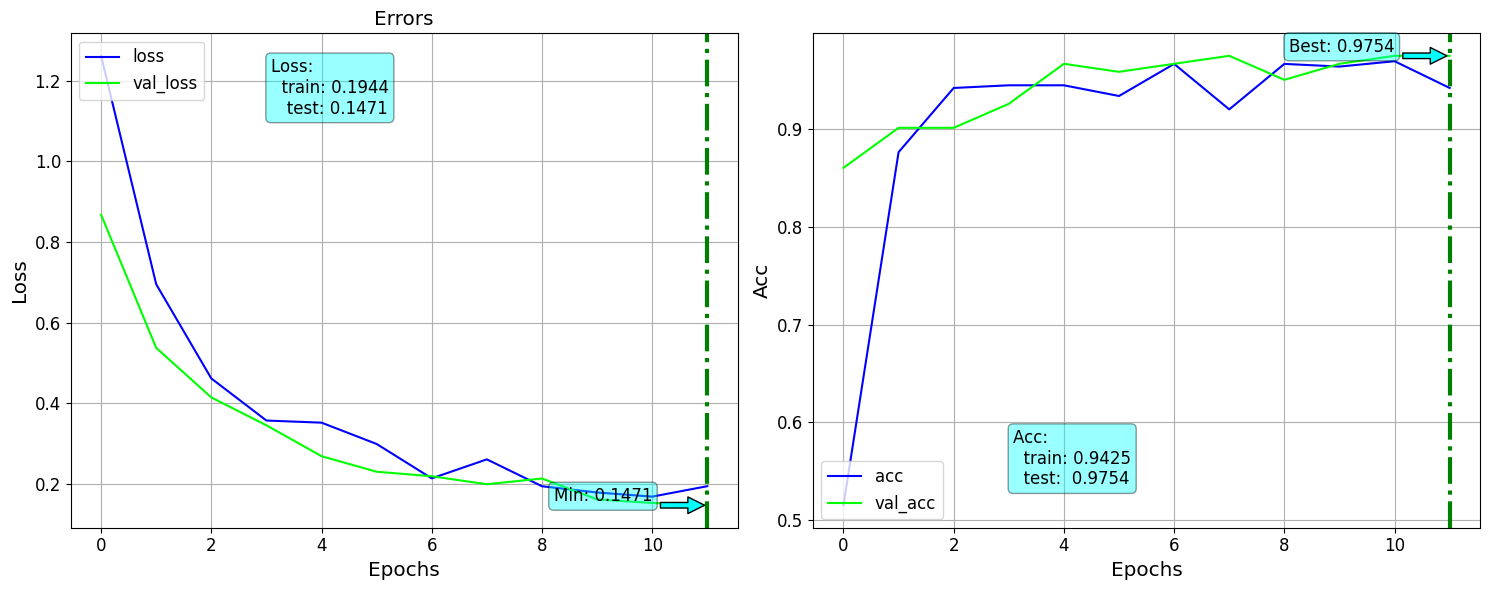

In [56]:
plot_tf_hist(loss_df)


## Predictions

In [57]:
def val_frames_extraction(video_path,SEQUENCE_LENGTH=5,TIME_SECODNS=3):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
        SEQUENCE_LENGTH: Nu,ber of frames per sub-video
        TIME_SECODNS: video to be divided into sub-videos of what duration
    Returns:
        vid_list: A list of list of sub-videos containing the resized and normalized frames.
    '''

    # Declare a list to store sub-videos and their frames.
    vid_list=[]
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)
    # Get Frame counts
    frame_count=video_reader.get(cv2.CAP_PROP_FRAME_COUNT)
    # Get FPS
    FPS=video_reader.get(cv2.CAP_PROP_FPS)
    # Find video length
    vid_len=frame_count/FPS
    # Finding frames in 3 seconds window
    thresh_frames=int(3*FPS)

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = int(thresh_frames/SEQUENCE_LENGTH)

    # Iterate through the Video Frames.
    n_videos=int(vid_len/3)
    print("Print division by three gives : ",round(vid_len/3,2),f"so dividing the full video into {n_videos} sub-videos")

    # Loop to dividide videos into subvideos and append to vid_list
    for i in range(n_videos):

      # counter for skipping window
      count=i*SEQUENCE_LENGTH

      # Initialize a list to store frames of sub videos
      frames_list=[]

      # split each sub video into frames equal to sequence length
      for frame_counter in range(SEQUENCE_LENGTH):

          # Set the current frame position of the video. and keep skipping to required frames
          video_reader.set(cv2.CAP_PROP_POS_FRAMES, (count + frame_counter) * skip_frames_window)

          # Reading the frame from the video.
          success, frame = video_reader.read()

          # Check if Video frame is not successfully read then break the loop
          if not success:
              break

          # Resize the Frame to fixed height and width.
          resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

          # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
          normalized_frame = resized_frame / 255

          # Append the normalized frame into the frames list
          frames_list.append(normalized_frame)

      # append the list of collected frames from sub-video to vid_list
      vid_list.append(frames_list)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return vid_list

In [58]:

def preprocess_pred(video_file_path="/content/video (1080p).mp4"):
    '''
    This function will call extract_frames function and apply transforms on each sub-video
    Args:
        video_file_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        vid_list: A list of transformed sub-videos containing the required preprocessed frames.
    '''

    # Extract the list of sub-videos and required frames.
    vid_list = val_frames_extraction(video_file_path)

    #loop over each sub_video and apply required transformation
    for i in range(len(vid_list)):

      #converting to numpy array
      vid_list[i]=np.asarray([vid_list[i]])
      # applying the r21d's specific transformations
      vid_list[i]=apply_tansforms(vid_list[i])[0]

    # Return processed vid_list
    return vid_list

In [59]:
# calling preprocess_pred()
video_list=preprocess_pred()

Print division by three gives :  4.13 so dividing the full video into 4 sub-videos


In [60]:
###-------------------
# Making Predictions
###-------------------

with torch.no_grad():
    # setting model mode to evaluation
    model.eval()
    # lists to store predictions and softmax probabilities for each sub-video
    y_preds=[]
    y_probas=[]

    #pass each sub video to model and store the predictions
    for i in video_list:
      # giving batch of 1 and getting predictions
      logits=model(i.unsqueeze(0).to(device))
      # getting softmax probabilities
      probas=(F.softmax(logits[0],dim=0)).to("cpu")
      # getting class with highest logit value
      pred=torch.argmax(logits, dim = 1).to("cpu").numpy()
      # append the predictions and probabilities to resp. lists
      y_preds.append(pred)
      y_probas.append(probas)


In [61]:
# getting the class anmes for the predicted values
class_predictions=[CLASSES_LIST[i[0]] for i in y_preds]

In [62]:
# printing probabilities and predicted classes side by side
print(CLASSES_LIST)
for i,j in zip(y_probas,class_predictions):
  print(i,j)

['WalkingWithDog', 'TaiChi', 'Swing', 'HorseRace']
tensor([0.6185, 0.0261, 0.0446, 0.3108]) WalkingWithDog
tensor([0.3451, 0.1320, 0.0558, 0.4671]) HorseRace
tensor([0.2467, 0.0320, 0.0613, 0.6600]) HorseRace
tensor([0.3417, 0.2173, 0.0266, 0.4144]) HorseRace
